Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/14/resnet_torch.ipynb

<a href="https://colab.research.google.com/github/codeboy5/probml-notebooks/blob/add-resnet-jax/notebooks-d2l/resnet_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax
import jax.numpy as jnp  # JAX NumPy
from jax import lax
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np  # Ordinary NumPy

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers

try:
    import torchvision
except ModuleNotFoundError:
    %pip install -qq torchvision
    import torchvision
try:
    from torch.utils import data
except ModuleNotFoundError:
    %pip install -qq torch
    from torch.utils import data
from torchvision import transforms

try:
    import tensorflow_datasets as tfds  # TFDS for MNIST
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds  # TFDS for MNIST

import random
import os
import time
from typing import Any, Callable, Sequence, Tuple
from functools import partial

rng = jax.random.PRNGKey(0)
!mkdir figures # for saving plots
ModuleDef = Any

mkdir: cannot create directory ‘figures’: File exists


# Residual block

In [3]:
class Residual(nn.Module):
    """The Residual block of ResNet."""

    filters: int
    conv: ModuleDef
    norm: ModuleDef
    strides: Tuple[int, int] = (1, 1)
    use_1x1conv: bool = False

    @nn.compact
    def __call__(self, x):
        residual = x

        x = self.conv(self.filters, (3, 3), self.strides)(x)
        x = self.norm()(x)
        x = nn.relu(x)

        x = self.conv(self.filters, (3, 3))(x)
        x = self.norm(scale_init=nn.initializers.zeros)(x)

        if self.use_1x1conv:
            residual = self.conv(self.filters, (1, 1), self.strides, name="conv_proj")(residual)
            residual = self.norm(name="norm_proj")(residual)

        return nn.relu(x + residual)

Example where number of input and output channels is the same.

In [4]:
train = False

conv = partial(nn.Conv, use_bias=False, dtype=jnp.float32)
norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=jnp.float32)

model = Residual(3, conv, norm)
batch = jnp.ones((4, 6, 6, 3))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)
output.shape

(4, 6, 6, 3)

Example where we change the number of channels.

In [5]:
model = Residual(6, conv, norm, use_1x1conv=True)
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)
output.shape

(4, 6, 6, 6)

Example where we change the number of channels and the spatial size.

In [6]:
model = Residual(6, conv, norm, (2, 2), True)
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch)
output.shape

(4, 3, 3, 6)

# Resnet block

We define a resnet block to be a sequence of residual blocks, where the first element in the sequence has a 1x1 convolution. However, the first such resnet block does not have 1x1 conv.

In [7]:
def resnet_block(num_channels, conv, norm, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, conv, norm, (2, 2), True))
        else:
            blk.append(Residual(num_channels, conv, norm))
    return blk

# The Full Resnet18 Model

In [8]:
class ResNet(nn.Module):
    @nn.compact
    def __call__(self, x, train: bool = True):

        conv = partial(nn.Conv, use_bias=False, dtype=jnp.float32)
        norm = partial(nn.BatchNorm, use_running_average=not train, momentum=0.9, epsilon=1e-5, dtype=jnp.float32)

        x = nn.Conv(64, (7, 7), (2, 2), padding=[(3, 3), (3, 3)], name="conv_init")(x)
        x = norm(name="bn_init")(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (3, 3), strides=(2, 2), padding="SAME")

        b2 = resnet_block(64, conv, norm, 2, True)
        b3 = resnet_block(128, conv, norm, 2)
        b4 = resnet_block(256, conv, norm, 2)
        b5 = resnet_block(512, conv, norm, 2)

        stages = [b2, b3, b4, b5]

        for stage in stages:
            for layer in stage:
                x = layer(x)

        x = jnp.mean(x, axis=(1, 2))  # Works as adaptive avg pooling
        x = nn.Dense(10, dtype=jnp.float32)(x)
        x = jnp.asarray(x, np.float32)

        return x

In [9]:
model = ResNet()
batch = jnp.ones((1, 224, 224, 1))  # (N, H, W, C) format
variables = model.init(jax.random.PRNGKey(0), batch)
output = model.apply(variables, batch, False)
output.shape

(1, 10)

# Train on Fashion-MNIST

We upscale images from 28x28 to 96x96, so that the input to the global average pooling layer has size 3x3 (since the network downscales by a factor of 32).

In [10]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=2),
    )

 #  Create train state

In [11]:
class TrainState(train_state.TrainState):
    batch_stats: Any

In [12]:
def create_train_state(rng, learning_rate, momentum):
    cnn = ResNet()
    variables = cnn.init(rng, jnp.ones([1, 96, 96, 1], jnp.float32))
    params, batch_stats = variables["params"], variables["batch_stats"]
    tx = optax.sgd(learning_rate, momentum)
    state = TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, batch_stats=batch_stats)
    return state

# Metric computation

In [13]:
def compute_metrics(*, logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

# Training step

In [14]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""

    def loss_fn(params):
        logits, new_model_state = state.apply_fn(
            {"params": params, "batch_stats": state.batch_stats}, batch["image"], mutable=["batch_stats"]
        )
        one_hot = jax.nn.one_hot(batch["label"], num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))

        return loss, (new_model_state, logits)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state.params)
    # grads = lax.pmean(grads, axis_name='batch')

    new_model_state, logits = aux[1]
    metrics = compute_metrics(logits=logits, labels=batch["label"])

    new_state = state.apply_gradients(grads=grads, batch_stats=new_model_state["batch_stats"])

    return new_state, metrics

In [15]:
def eval_step(state, batch):
    variables = {"params": state.params, "batch_stats": state.batch_stats}
    logits = state.apply_fn(variables, batch["image"], train=False, mutable=False)
    return compute_metrics(logits=logits, labels=batch["label"])

In [16]:
def eval_model(state, test_iter):

    batch_metrics = []

    for i, (X, y) in enumerate(test_iter):
        batch = {}
        batch["image"] = jnp.reshape(jnp.float32(X), (-1, 96, 96, 1))
        batch["label"] = jnp.float32(y)
        metrics = eval_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    return epoch_metrics_np["accuracy"]

# Plotting

In [17]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [18]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Train function

In [25]:
train_iter, test_iter = load_data_fashion_mnist(256, resize=96)

In [26]:
rng, init_rng = jax.random.split(rng)

In [27]:
learning_rate = 0.1
momentum = 0.9

In [28]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [29]:
num_epochs = 10

epoch: 9, loss: 0.0608, train_accuracy: 97.78, test_accuracy: 90.72


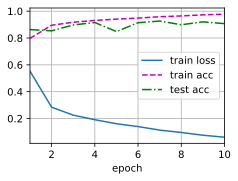

In [30]:
animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])

for epoch in range(num_epochs):

    batch_metrics = []

    for i, (X, y) in enumerate(train_iter):
        batch = {}
        batch["image"] = jnp.reshape(jnp.float32(X), (-1, 96, 96, 1))
        batch["label"] = jnp.float32(y)
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    animator.add(epoch + 1, (epoch_metrics_np["loss"], epoch_metrics_np["accuracy"], None))
    acc = eval_model(state, test_iter)
    animator.add(epoch + 1, (None, None, acc))

    print(
        "epoch: %d, loss: %.4f, train_accuracy: %.2f, test_accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100, acc * 100)
    )